# Imports

In [4]:
import os
import sys
import subprocess
import random
import zipfile
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

try:
    from pycocotools.coco import COCO
except ImportError:
    COCO = None

try:
    import wget
except ImportError:
    wget = None

try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    drive = None
    IN_COLAB = False

train_images_dir = None
val_images_dir = None
annotations_dir = None
train_ann_file = None
val_ann_file = None
data_dir = None

# Phase 1: Data Processing Pipeline

This notebook builds a **data processing pipeline** for Human Pose Estimation with the COCO dataset. It covers:

1. **Setup & Dependencies**
2. **Data Download & Organization**
3. **Dataset & DataLoader Implementation**
4. **Keypoint-Aware Augmentation**
5. **Visualization & Validation**

## Step 1: Environment Setup & Dependencies

In [5]:
def setup_environment():
    global COCO, wget, drive

    packages_to_install = []

    if COCO is None:
        packages_to_install.append('pycocotools')
    if wget is None:
        packages_to_install.append('wget')
    packages_to_install.extend(['opencv-python', 'matplotlib'])

    if packages_to_install:
        for package in packages_to_install:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

    if COCO is None:
        from pycocotools.coco import COCO
        globals()['COCO'] = COCO

    if wget is None:
        import wget
        globals()['wget'] = wget

    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    return True

setup_success = setup_environment()

## Step 2: Data Download & Preparation

In [6]:
def prepare_data_directories():
    global data_dir, train_images_dir, val_images_dir, annotations_dir, train_ann_file, val_ann_file

    if drive is not None:
        try:
            drive.mount('/content/drive')
            data_dir = "/content/drive/MyDrive/ColabDataset/coco_full"
        except:
            data_dir = "./coco_data"
    else:
        data_dir = "./coco_data"

    Path(data_dir).mkdir(parents=True, exist_ok=True)

    urls = {
        "train2017": "http://images.cocodataset.org/zips/train2017.zip",
        "val2017": "http://images.cocodataset.org/zips/val2017.zip",
        "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    }

    def download_and_extract(name, url):
        zip_path = os.path.join(data_dir, f"{name}.zip")
        extract_path = os.path.join(data_dir, name)

        if os.path.exists(extract_path) and os.listdir(extract_path):
            return True

        if not os.path.exists(zip_path):
            if wget is not None:
                wget.download(url, zip_path)
            else:
                return False

        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(data_dir)
            return True
        except:
            return False

    success = True
    for key, url in urls.items():
        if not download_and_extract(key, url):
            success = False
            break

    if success:
        train_images_dir = os.path.join(data_dir, "train2017")
        val_images_dir = os.path.join(data_dir, "val2017")
        annotations_dir = os.path.join(data_dir, "annotations")
        train_ann_file = os.path.join(annotations_dir, "person_keypoints_train2017.json")
        val_ann_file = os.path.join(annotations_dir, "person_keypoints_val2017.json")

        critical_files = [train_ann_file, val_ann_file]
        missing_files = [f for f in critical_files if not os.path.exists(f)]

        if missing_files:
            return False

    return success

data_success = prepare_data_directories()

## Step 3: Dataset Implementation

In [7]:
def create_dataset_classes():
    global COCODataset, get_dataloader

    class COCODataset(Dataset):
        def __init__(self, annotation_file, image_dir, transform=None):
            if not os.path.exists(annotation_file):
                raise FileNotFoundError(f"Annotation file {annotation_file} not found.")
            if not os.path.exists(image_dir):
                raise FileNotFoundError(f"Image directory {image_dir} not found.")

            self.coco = COCO(annotation_file)
            self.image_dir = image_dir
            self.transform = transform

            all_img_ids = self.coco.getImgIds(catIds=[1])
            self.img_ids = []
            for img_id in all_img_ids:
                img_info = self.coco.loadImgs(img_id)[0]
                img_path = os.path.join(self.image_dir, img_info['file_name'])
                if os.path.exists(img_path):
                    self.img_ids.append(img_id)

        def __len__(self):
            return len(self.img_ids)

        def __getitem__(self, idx):
            img_id = self.img_ids[idx]
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.image_dir, img_info['file_name'])
            img = cv2.imread(img_path)
            img = img[:, :, ::-1]

            orig_h, orig_w = img.shape[:2]
            img_resized = cv2.resize(img, (256, 256))

            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=[1])
            anns = self.coco.loadAnns(ann_ids)

            keypoints_list = []
            for ann in anns:
                if 'keypoints' in ann and np.sum(ann['keypoints']) > 0:
                    kps = np.array(ann['keypoints']).reshape(-1, 3)[:, :2]
                    keypoints_list.append(kps)
            keypoints = keypoints_list[0] if keypoints_list else np.zeros((17, 2))

            keypoints[:, 0] = keypoints[:, 0] * 256 / orig_w
            keypoints[:, 1] = keypoints[:, 1] * 256 / orig_h

            img_tensor = torch.tensor(img_resized).permute(2, 0, 1).float() / 255.0

            if self.transform is not None:
                img_tensor, keypoints = self.transform(img_tensor, keypoints)

            return img_tensor, keypoints

    def get_dataloader(annotation_file, image_dir, batch_size=4, transform=None):
        dataset = COCODataset(annotation_file, image_dir, transform=transform)
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return COCODataset, get_dataloader

try:
    COCODataset, get_dataloader = create_dataset_classes()
    dataset_success = True
except Exception as e:
    dataset_success = False

## Step 4: Data Augmentation with Keypoint Transformations

In [8]:
def create_augmentation_transforms():
    global KeypointTransform, DebugTransform

    class KeypointTransform:
        def __init__(self, flip_prob=0.5, rotation_degrees=10, brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1):
            self.flip_prob = flip_prob
            self.rotation_degrees = rotation_degrees
            self.brightness = brightness
            self.contrast = contrast
            self.saturation = saturation
            self.hue = hue

        def __call__(self, image, keypoints):
            if torch.is_tensor(image):
                image = TF.to_pil_image(image)

            img_width, img_height = image.size
            was_flipped = False
            rotation_angle = 0

            if random.random() < self.flip_prob:
                image = TF.hflip(image)
                was_flipped = True

            if self.rotation_degrees > 0:
                rotation_angle = random.uniform(-self.rotation_degrees, self.rotation_degrees)
                image = TF.rotate(image, rotation_angle)

            if self.brightness > 0 or self.contrast > 0 or self.saturation > 0 or self.hue > 0:
                image = TF.adjust_brightness(image, 1 + random.uniform(-self.brightness, self.brightness))
                image = TF.adjust_contrast(image, 1 + random.uniform(-self.contrast, self.contrast))
                image = TF.adjust_saturation(image, 1 + random.uniform(-self.saturation, self.saturation))
                image = TF.adjust_hue(image, random.uniform(-self.hue, self.hue))

            image = TF.to_tensor(image)
            transformed_keypoints = keypoints.copy()

            if was_flipped:
                transformed_keypoints[:, 0] = img_width - 1 - transformed_keypoints[:, 0]
                swap_pairs = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]
                for left_idx, right_idx in swap_pairs:
                    if left_idx < len(transformed_keypoints) and right_idx < len(transformed_keypoints):
                        transformed_keypoints[[left_idx, right_idx]] = transformed_keypoints[[right_idx, left_idx]]

            if abs(rotation_angle) > 0:
                center_x, center_y = img_width / 2, img_height / 2
                angle_rad = np.radians(-rotation_angle)
                cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)

                x_centered = transformed_keypoints[:, 0] - center_x
                y_centered = transformed_keypoints[:, 1] - center_y

                x_rotated = x_centered * cos_angle - y_centered * sin_angle
                y_rotated = x_centered * sin_angle + y_centered * cos_angle

                transformed_keypoints[:, 0] = x_rotated + center_x
                transformed_keypoints[:, 1] = y_rotated + center_y

                transformed_keypoints[:, 0] = np.clip(transformed_keypoints[:, 0], 0, img_width - 1)
                transformed_keypoints[:, 1] = np.clip(transformed_keypoints[:, 1], 0, img_height - 1)

            return image, transformed_keypoints

    class DebugTransform:
        def __init__(self, flip=False, rotation=0):
            self.flip = flip
            self.rotation = rotation

        def __call__(self, image, keypoints):
            if torch.is_tensor(image):
                image = TF.to_pil_image(image)

            img_width, img_height = image.size
            transformed_keypoints = keypoints.copy()

            if self.flip:
                image = TF.hflip(image)
                transformed_keypoints[:, 0] = img_width - 1 - transformed_keypoints[:, 0]
                swap_pairs = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]
                for left_idx, right_idx in swap_pairs:
                    if left_idx < len(transformed_keypoints) and right_idx < len(transformed_keypoints):
                        transformed_keypoints[[left_idx, right_idx]] = transformed_keypoints[[right_idx, left_idx]]

            if self.rotation != 0:
                image = TF.rotate(image, self.rotation)
                center_x, center_y = img_width / 2, img_height / 2
                angle_rad = np.radians(-self.rotation)
                cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)

                x_centered = transformed_keypoints[:, 0] - center_x
                y_centered = transformed_keypoints[:, 1] - center_y

                x_rotated = x_centered * cos_angle - y_centered * sin_angle
                y_rotated = x_centered * sin_angle + y_centered * cos_angle

                transformed_keypoints[:, 0] = x_rotated + center_x
                transformed_keypoints[:, 1] = y_rotated + center_y

                transformed_keypoints[:, 0] = np.clip(transformed_keypoints[:, 0], 0, img_width - 1)
                transformed_keypoints[:, 1] = np.clip(transformed_keypoints[:, 1], 0, img_height - 1)

            return TF.to_tensor(image), transformed_keypoints

    return KeypointTransform, DebugTransform

try:
    KeypointTransform, DebugTransform = create_augmentation_transforms()
    transform_success = True
except Exception as e:
    transform_success = False

## Step 5: Visualization & Validation

In [9]:
def create_visualization_functions():
    global visualize_basic_batch, visualize_augmentation_comparison, visualize_debug_transformations

    def visualize_basic_batch(data_loader, title="Dataset Samples"):
        images, keypoints_batch = next(iter(data_loader))
        fig, axes = plt.subplots(1, len(images), figsize=(16, 4))

        if len(images) == 1:
            axes = [axes]

        for i, img in enumerate(images):
            img_np = img.permute(1, 2, 0).numpy()
            axes[i].imshow(img_np)
            axes[i].scatter(keypoints_batch[i][:, 0], keypoints_batch[i][:, 1],
                          c='red', s=40, alpha=0.8, edgecolors='white', linewidth=1)
            axes[i].set_title(f'{title} {i+1}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    def visualize_augmentation_comparison():
        custom_transform = KeypointTransform(
            flip_prob=1.0, rotation_degrees=20, brightness=0.2,
            contrast=0.2, saturation=0.2, hue=0.05
        )

        no_transform_loader = get_dataloader(val_ann_file, val_images_dir, batch_size=2, transform=None)
        transform_loader = get_dataloader(val_ann_file, val_images_dir, batch_size=2, transform=custom_transform)

        torch.manual_seed(42)
        original_images, original_keypoints = next(iter(no_transform_loader))

        torch.manual_seed(42)
        transformed_images, transformed_keypoints = next(iter(transform_loader))

        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        for i in range(2):
            img_np = original_images[i].permute(1, 2, 0).numpy()
            axes[0, i].imshow(img_np)
            axes[0, i].scatter(original_keypoints[i][:, 0], original_keypoints[i][:, 1],
                             c='red', s=50, alpha=0.8, edgecolors='white', linewidth=1)
            axes[0, i].set_title(f'Original {i+1}', fontsize=14)
            axes[0, i].axis('off')

        for i in range(2):
            img_np = transformed_images[i].permute(1, 2, 0).numpy()
            axes[1, i].imshow(img_np)
            axes[1, i].scatter(transformed_keypoints[i][:, 0], transformed_keypoints[i][:, 1],
                             c='blue', s=50, alpha=0.8, edgecolors='white', linewidth=1)
            axes[1, i].set_title(f'Transformed {i+1}', fontsize=14)
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    def visualize_debug_transformations():
        transforms_to_test = [
            ("Original", None),
            ("Horizontal Flip", DebugTransform(flip=True)),
            ("Rotation 15°", DebugTransform(rotation=15)),
            ("Rotation 30°", DebugTransform(rotation=30)),
            ("Rotation -15°", DebugTransform(rotation=-15)),
            ("Flip + Rotate 15°", DebugTransform(flip=True, rotation=15)),
            ("Flip + Rotate 30°", DebugTransform(flip=True, rotation=30)),
            ("Flip + Rotate -15°", DebugTransform(flip=True, rotation=-15))
        ]

        sample_dataset = COCODataset(val_ann_file, val_images_dir, transform=None)
        sample_img1, sample_kpts1 = sample_dataset[0]
        sample_img2, sample_kpts2 = sample_dataset[1]

        fig, axes = plt.subplots(2, 4, figsize=(20, 10))

        for i in range(4):
            title, transform = transforms_to_test[i]
            if transform is None:
                img_show = sample_img1
                kpts_show = sample_kpts1
            else:
                img_show, kpts_show = transform(sample_img1, sample_kpts1)

            img_np = img_show.permute(1, 2, 0).numpy()
            axes[0, i].imshow(img_np)
            axes[0, i].scatter(kpts_show[:, 0], kpts_show[:, 1], c='red', s=50, alpha=0.8, edgecolors='white', linewidth=1)
            axes[0, i].set_title(f'{title} - Sample 1', fontsize=12)
            axes[0, i].axis('off')

        for i in range(4):
            title, transform = transforms_to_test[i + 4]
            if transform is None:
                img_show = sample_img2
                kpts_show = sample_kpts2
            else:
                img_show, kpts_show = transform(sample_img2, sample_kpts2)

            img_np = img_show.permute(1, 2, 0).numpy()
            axes[1, i].imshow(img_np)
            axes[1, i].scatter(kpts_show[:, 0], kpts_show[:, 1], c='blue', s=50, alpha=0.8, edgecolors='white', linewidth=1)
            axes[1, i].set_title(f'{title} - Sample 2', fontsize=12)
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    return visualize_basic_batch, visualize_augmentation_comparison, visualize_debug_transformations

try:
    vis_basic, vis_aug, vis_debug = create_visualization_functions()
    visualization_success = True
except Exception as e:
    visualization_success = False

## Pipeline Execution

loading annotations into memory...
Done (t=8.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


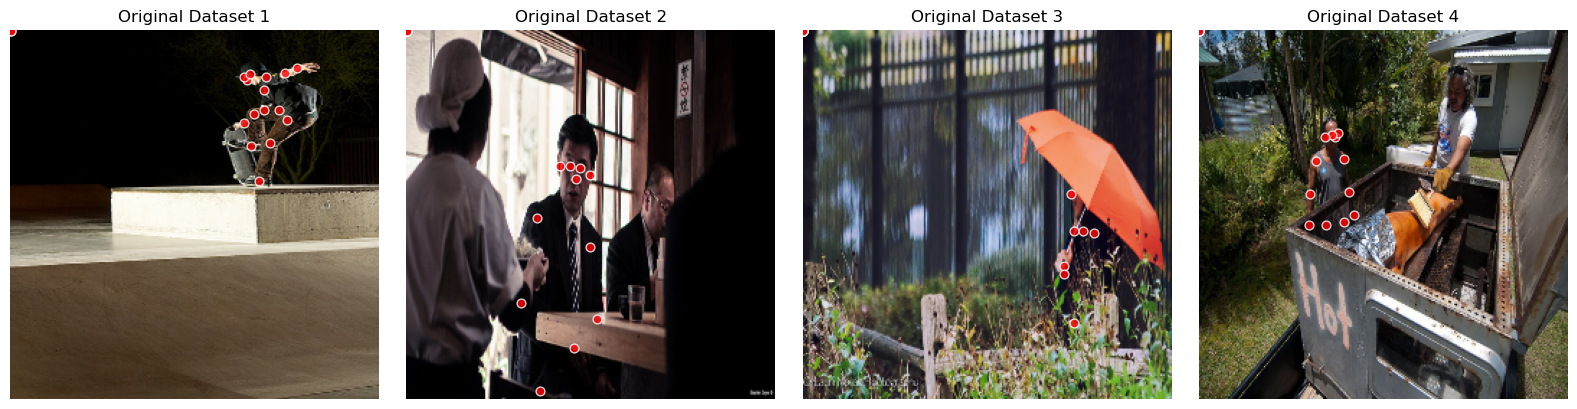

loading annotations into memory...
Done (t=1.69s)
creating index...
index created!
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


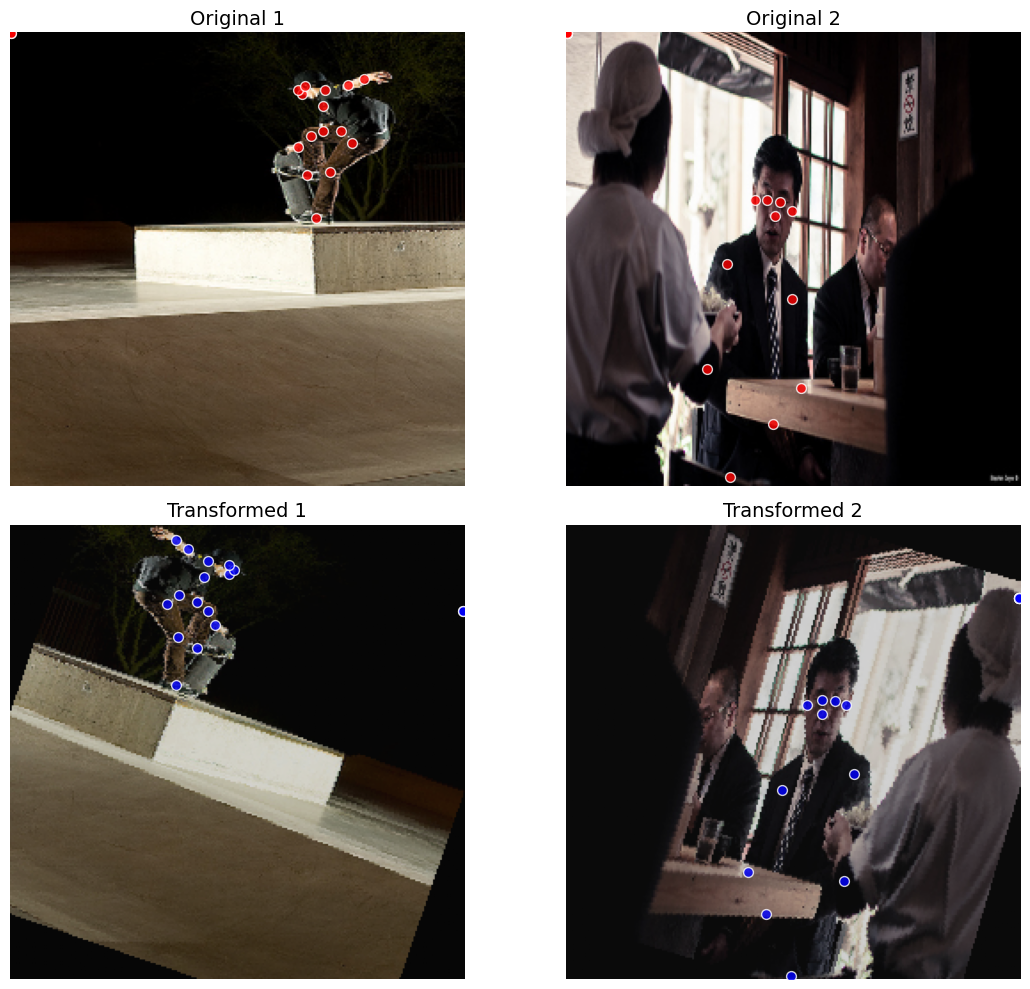

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


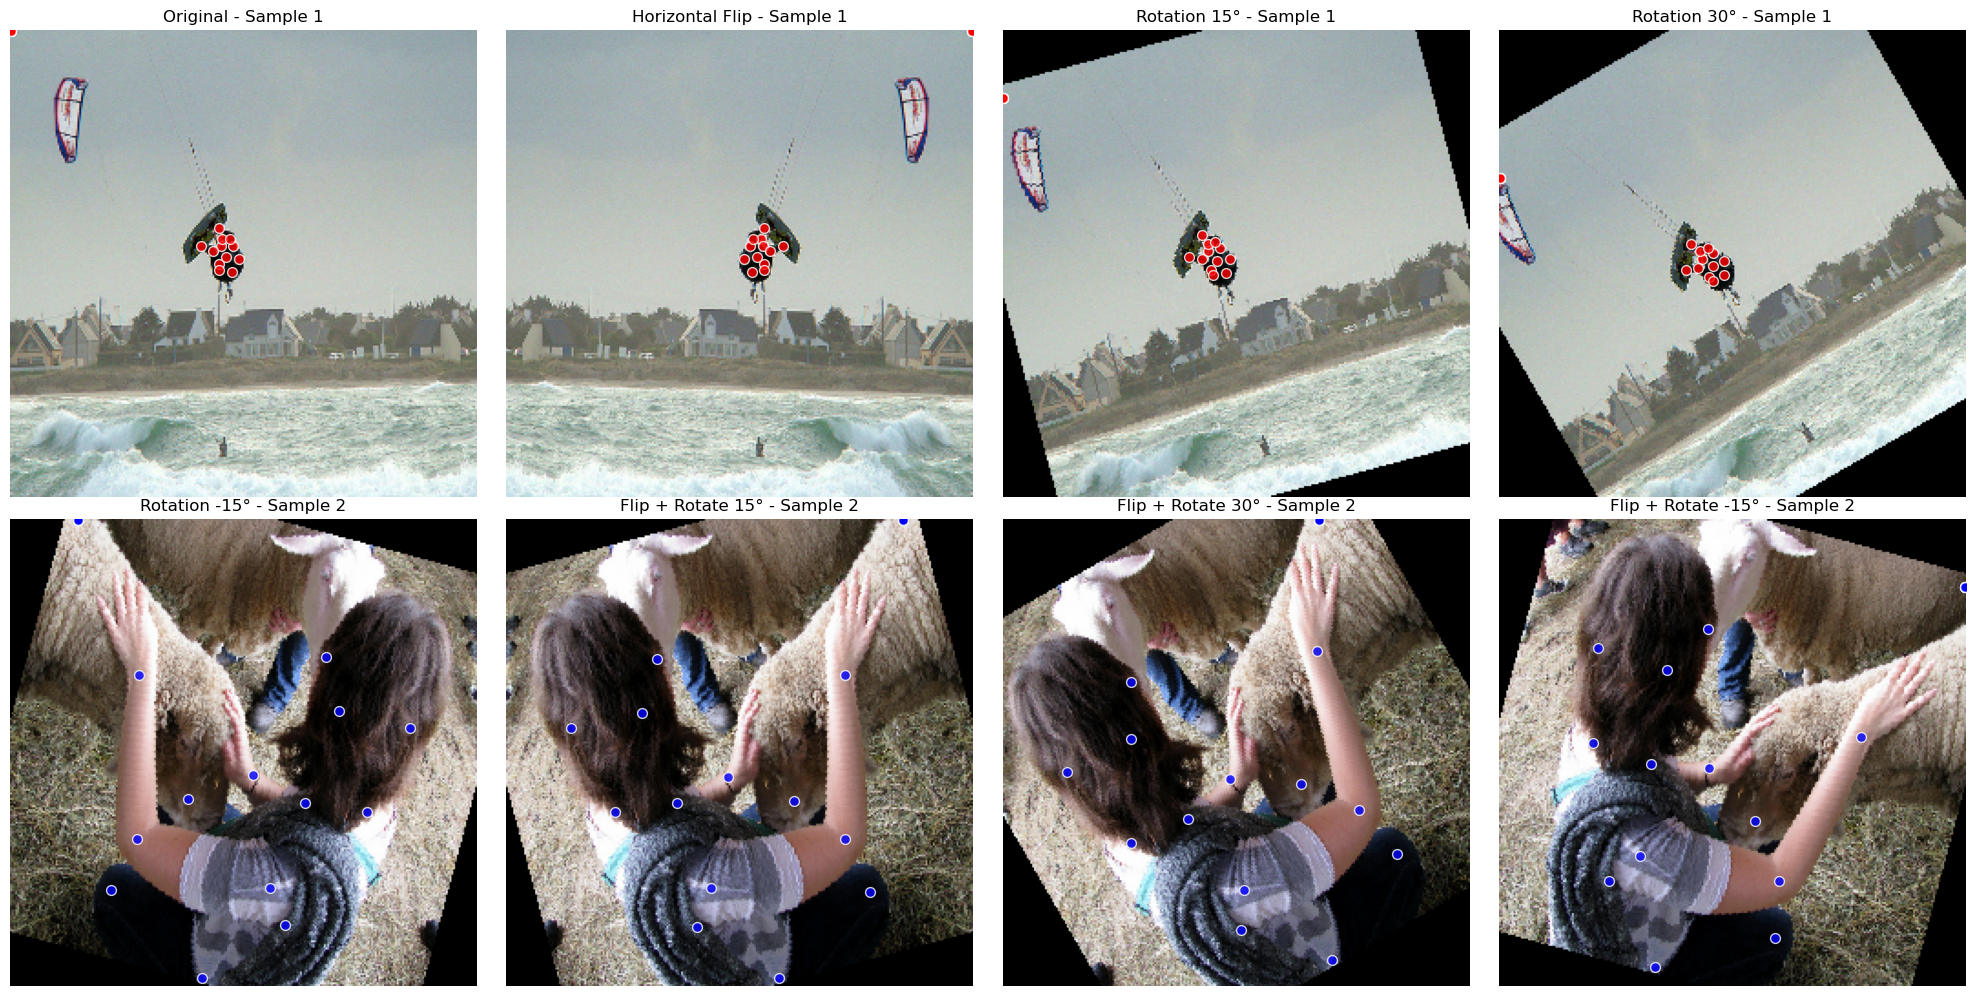

In [10]:
def execute_pipeline():
    if not all([setup_success, data_success, dataset_success, transform_success, visualization_success]):
        return False

    train_loader = get_dataloader(train_ann_file, train_images_dir, batch_size=4)
    val_loader = get_dataloader(val_ann_file, val_images_dir, batch_size=4)

    visualize_basic_batch(val_loader, "Original Dataset")
    visualize_augmentation_comparison()
    visualize_debug_transformations()

    return True

pipeline_success = execute_pipeline()

# Phase 2: Streamlined Experimentation Architecture

**Simple Dictionary-Driven Experiments**: Just define a config dict and run!

```python
# Example experiment configuration
experiment = {
    'name': 'lightweight_test',
    'backbone': 'mobilenet_v2',  # simple, resnet18, mobilenet_v2
    'head': 'simple',            # simple, deconv
    'loss': 'mse',               # mse, smooth_l1
    'epochs': 10,
    'lr': 1e-3,
    'batch_size': 8
}
run_experiment(experiment)
```

## Core Components (Minimal Implementation)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.hub import load_state_dict_from_url

def create_backbone_models():
    """Factory for creating different backbone architectures"""

    class BaseBackbone(nn.Module):
        """Base class for all backbones"""
        def __init__(self):
            super().__init__()
            self.output_channels = None

        def forward(self, x):
            raise NotImplementedError

    class SimpleConvBackbone(BaseBackbone):
        """Simple CNN backbone for quick experiments"""
        def __init__(self, input_channels=3):
            super().__init__()
            self.output_channels = 256

            self.layers = nn.Sequential(
                # Block 1
                nn.Conv2d(input_channels, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),

                # Block 2
                nn.Conv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),

                # Block 3
                nn.Conv2d(128, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),

                # Block 4
                nn.Conv2d(256, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
            )

        def forward(self, x):
            return self.layers(x)

    class ResNetBackbone(BaseBackbone):
        """ResNet-based backbone with different depths"""
        def __init__(self, depth=18, pretrained=True):
            super().__init__()

            if depth == 18:
                from torchvision.models import resnet18
                backbone = resnet18(pretrained=pretrained)
                self.output_channels = 512
            elif depth == 34:
                from torchvision.models import resnet34
                backbone = resnet34(pretrained=pretrained)
                self.output_channels = 512
            elif depth == 50:
                from torchvision.models import resnet50
                backbone = resnet50(pretrained=pretrained)
                self.output_channels = 2048
            else:
                raise ValueError(f"Unsupported ResNet depth: {depth}")

            # Remove the final avgpool and fc layers
            self.features = nn.Sequential(*list(backbone.children())[:-2])

        def forward(self, x):
            return self.features(x)

    class MobileNetBackbone(BaseBackbone):
        """MobileNet backbone for mobile/edge deployment"""
        def __init__(self, version='v2', pretrained=True):
            super().__init__()

            if version == 'v2':
                from torchvision.models import mobilenet_v2
                backbone = mobilenet_v2(pretrained=pretrained)
                self.output_channels = 1280
                self.features = backbone.features
            else:
                raise ValueError(f"Unsupported MobileNet version: {version}")

        def forward(self, x):
            return self.features(x)

    class EfficientNetBackbone(BaseBackbone):
        """EfficientNet backbone for balanced efficiency/accuracy"""
        def __init__(self, version='b0', pretrained=True):
            super().__init__()

            try:
                from torchvision.models import efficientnet_b0, efficientnet_b1, efficientnet_b2

                if version == 'b0':
                    backbone = efficientnet_b0(pretrained=pretrained)
                    self.output_channels = 1280
                elif version == 'b1':
                    backbone = efficientnet_b1(pretrained=pretrained)
                    self.output_channels = 1280
                elif version == 'b2':
                    backbone = efficientnet_b2(pretrained=pretrained)
                    self.output_channels = 1408
                else:
                    raise ValueError(f"Unsupported EfficientNet version: {version}")

                self.features = backbone.features
            except ImportError:
                print("EfficientNet not available, falling back to ResNet18")
                backbone = ResNetBackbone(depth=18, pretrained=pretrained)
                self.features = backbone.features
                self.output_channels = backbone.output_channels

        def forward(self, x):
            return self.features(x)

    # Factory function
    def get_backbone(name, **kwargs):
        """Factory function to create backbones"""
        backbones = {
            'simple': SimpleConvBackbone,
            'resnet18': lambda: ResNetBackbone(depth=18, **kwargs),
            'resnet34': lambda: ResNetBackbone(depth=34, **kwargs),
            'resnet50': lambda: ResNetBackbone(depth=50, **kwargs),
            'mobilenet_v2': lambda: MobileNetBackbone(version='v2', **kwargs),
            'efficientnet_b0': lambda: EfficientNetBackbone(version='b0', **kwargs),
            'efficientnet_b1': lambda: EfficientNetBackbone(version='b1', **kwargs),
        }

        if name not in backbones:
            raise ValueError(f"Unknown backbone: {name}. Available: {list(backbones.keys())}")

        return backbones[name]()

    return get_backbone, SimpleConvBackbone, ResNetBackbone, MobileNetBackbone, EfficientNetBackbone

# Create the backbone factory and classes
get_backbone, SimpleConvBackbone, ResNetBackbone, MobileNetBackbone, EfficientNetBackbone = create_backbone_models()

print("Backbone models created successfully!")
print(f"Available backbones: {['simple', 'resnet18', 'resnet34', 'resnet50', 'mobilenet_v2', 'efficientnet_b0', 'efficientnet_b1']}")

Backbone models created successfully!
Available backbones: ['simple', 'resnet18', 'resnet34', 'resnet50', 'mobilenet_v2', 'efficientnet_b0', 'efficientnet_b1']


In [12]:
# ============================================================================
# HEATMAP PROCESSING
# ============================================================================

def keypoints_to_heatmaps(keypoints, heatmap_size=64, sigma=2.0):
    """Convert keypoints to Gaussian heatmaps"""
    num_keypoints = keypoints.shape[0]
    heatmaps = np.zeros((num_keypoints, heatmap_size, heatmap_size), dtype=np.float32)

    for i, (x, y) in enumerate(keypoints):
        if x > 0 and y > 0:  # Valid keypoint
            # Scale to heatmap size
            x_scaled = x * heatmap_size / 256
            y_scaled = y * heatmap_size / 256

            # Create Gaussian heatmap
            xx, yy = np.meshgrid(np.arange(heatmap_size), np.arange(heatmap_size))
            heatmap = np.exp(-((xx - x_scaled) ** 2 + (yy - y_scaled) ** 2) / (2 * sigma ** 2))
            heatmaps[i] = heatmap

    return heatmaps

print("Heatmap processing ready!")


Heatmap processing ready!


In [13]:
# ============================================================================
# POSE MODEL ARCHITECTURE
# ============================================================================

class PoseModel(nn.Module):
    """Complete pose estimation model with configurable backbone and head"""
    
    def __init__(self, backbone_name='simple', head_name='simple'):
        super().__init__()
        self.backbone_name = backbone_name
        self.head_name = head_name
        
        # Create backbone
        self.backbone = get_backbone(backbone_name, pretrained=True)
        
        # Create head based on type
        if head_name == 'simple':
            self.head = SimpleHead(self.backbone.output_channels)
        elif head_name == 'deconv':
            self.head = DeconvHead(self.backbone.output_channels)
        else:
            raise ValueError(f"Unknown head: {head_name}")
    
    def forward(self, x):
        features = self.backbone(x)
        heatmaps = self.head(features)
        return heatmaps

class SimpleHead(nn.Module):
    """Simple head that reduces channels to keypoint heatmaps"""
    
    def __init__(self, input_channels, num_keypoints=17, heatmap_size=64):
        super().__init__()
        self.num_keypoints = num_keypoints
        self.heatmap_size = heatmap_size
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, num_keypoints, 1),
        )
        
        self.upsample = nn.Upsample(size=(heatmap_size, heatmap_size), mode='bilinear', align_corners=False)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.upsample(x)
        return x

class DeconvHead(nn.Module):
    """Deconvolutional head for higher quality heatmaps"""
    
    def __init__(self, input_channels, num_keypoints=17, heatmap_size=64):
        super().__init__()
        self.num_keypoints = num_keypoints
        self.heatmap_size = heatmap_size
        
        self.deconv_layers = nn.Sequential(
            # First deconv block
            nn.ConvTranspose2d(input_channels, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Second deconv block
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # Third deconv block
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Final layer to keypoints
            nn.Conv2d(64, num_keypoints, 1),
        )
        
        # Adaptive pooling to ensure correct output size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((heatmap_size, heatmap_size))
    
    def forward(self, x):
        x = self.deconv_layers(x)
        # Ensure output is exactly the right size
        if x.size(2) != self.heatmap_size or x.size(3) != self.heatmap_size:
            x = self.adaptive_pool(x)
        return x

# ============================================================================
# LOSS FUNCTIONS
# ============================================================================

def get_loss_fn(loss_name):
    """Factory function for loss functions"""
    
    if loss_name == 'mse':
        return nn.MSELoss()
    elif loss_name == 'smooth_l1':
        return nn.SmoothL1Loss()
    elif loss_name == 'l1':
        return nn.L1Loss()
    else:
        raise ValueError(f"Unknown loss function: {loss_name}")

print("PoseModel and loss functions created successfully!")
print(f"Available heads: {['simple', 'deconv']}")
print(f"Available losses: {['mse', 'smooth_l1', 'l1']}")

PoseModel and loss functions created successfully!
Available heads: ['simple', 'deconv']
Available losses: ['mse', 'smooth_l1', 'l1']


In [14]:
# ============================================================================
# EXPERIMENT RUNNER - JUST DEFINE CONFIG DICT AND RUN!
# ============================================================================

def run_experiment(config):
    """
    Run pose estimation experiment with simple config dict

    config = {
        'name': 'experiment_name',
        'backbone': 'simple' | 'resnet18' | 'mobilenet_v2',
        'head': 'simple' | 'deconv',
        'loss': 'mse' | 'smooth_l1',
        'epochs': int,
        'lr': float,
        'batch_size': int
    }
    """
    print(f"Running Experiment: {config['name']}")
    print(f"Config: {config}")

    # Check if we have data from Phase 1
    if not all([train_ann_file, val_ann_file, train_images_dir, val_images_dir]):
        print("ERROR: Phase 1 data not available. Run Phase 1 first!")
        return None

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️  Device: {device}")

    # Create model
    model = PoseModel(config['backbone'], config['head']).to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model: {config['backbone']} + {config['head']} ({total_params:,} params)")

    # Create loss and optimizer
    criterion = get_loss_fn(config['loss'])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

    # Create data loaders
    train_loader = get_dataloader(train_ann_file, train_images_dir, batch_size=config['batch_size'])
    val_loader = get_dataloader(val_ann_file, val_images_dir, batch_size=config['batch_size'])

    print(f"Data: {len(train_loader)} train batches, {len(val_loader)} val batches")

    # Training loop
    print(f"Training for {config['epochs']} epochs...")
    train_losses, val_losses = [], []
    best_val_loss = float('inf')

    for epoch in range(config['epochs']):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (images, keypoints) in enumerate(train_loader):
            images = images.to(device)

            # Convert keypoints to heatmaps
            batch_heatmaps = []
            for kpts in keypoints:
                heatmaps = keypoints_to_heatmaps(kpts.numpy())
                batch_heatmaps.append(heatmaps)
            target_heatmaps = torch.tensor(np.stack(batch_heatmaps), dtype=torch.float32).to(device)

            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, target_heatmaps)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 20 == 0:
                print(f"  Epoch {epoch+1:2d} [{batch_idx:3d}/{len(train_loader):3d}] Loss: {loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, keypoints in val_loader:
                images = images.to(device)
                batch_heatmaps = []
                for kpts in keypoints:
                    heatmaps = keypoints_to_heatmaps(kpts.numpy())
                    batch_heatmaps.append(heatmaps)
                target_heatmaps = torch.tensor(np.stack(batch_heatmaps), dtype=torch.float32).to(device)

                predictions = model(images)
                loss = criterion(predictions, target_heatmaps)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f"{config['name']}_best.pth")
            print(f"  NEW BEST MODEL! Val Loss: {avg_val_loss:.4f}")

        print(f"  Epoch {epoch+1:2d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    print(f"Training completed! Best Val Loss: {best_val_loss:.4f}")

    # Return results
    results = {
        'config': config,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'model_params': total_params
    }

    return results

print("Experiment runner ready!")

Experiment runner ready!


## Experiment 1: Lightweight Configuration

Starting Experiment 1...
This will train a lightweight pose estimation model suitable for mobile deployment.
Expected training time: ~30 minutes
Running Experiment: lightweight_mobilenet
Config: {'name': 'lightweight_mobilenet', 'backbone': 'mobilenet_v2', 'head': 'simple', 'loss': 'mse', 'epochs': 15, 'lr': 0.001, 'batch_size': 8}
🖥️  Device: cuda


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/super/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100.0%


Model: mobilenet_v2 + simple (5,471,249 params)
loading annotations into memory...
Done (t=6.83s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
Data: 8015 train batches, 337 val batches
Training for 15 epochs...
  Epoch  1 [  0/8015] Loss: 0.1089
  Epoch  1 [ 20/8015] Loss: 0.0038
  Epoch  1 [ 40/8015] Loss: 0.0022
  Epoch  1 [ 60/8015] Loss: 0.0022
  Epoch  1 [ 80/8015] Loss: 0.0025
  Epoch  1 [100/8015] Loss: 0.0020
  Epoch  1 [120/8015] Loss: 0.0023
  Epoch  1 [140/8015] Loss: 0.0022
  Epoch  1 [160/8015] Loss: 0.0019
  Epoch  1 [180/8015] Loss: 0.0019
  Epoch  1 [200/8015] Loss: 0.0015
  Epoch  1 [220/8015] Loss: 0.0013
  Epoch  1 [240/8015] Loss: 0.0017
  Epoch  1 [260/8015] Loss: 0.0019
  Epoch  1 [280/8015] Loss: 0.0022
  Epoch  1 [300/8015] Loss: 0.0015
  Epoch  1 [320/8015] Loss: 0.0019
  Epoch  1 [340/8015] Loss: 0.0018
  Epoch  1 [360/8015] Loss: 0.0020
  Epoch  1 [380/8015] Loss: 0.0019
  Epoch  1 [400/80

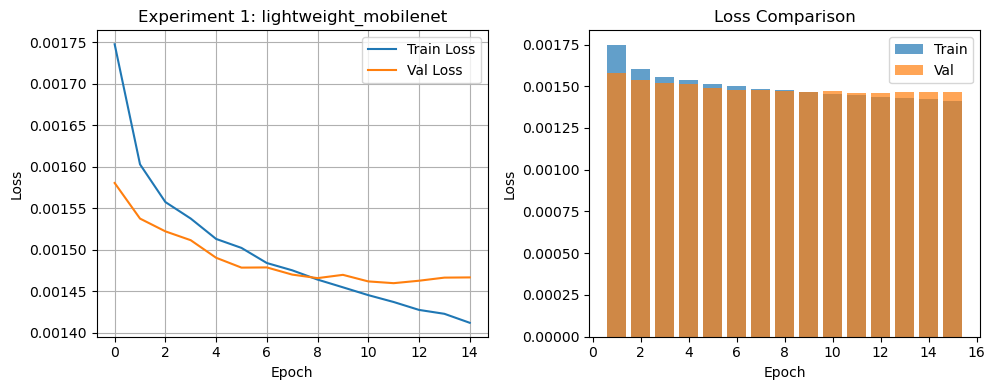

\nNext steps:
  • Try different backbones: 'simple', 'resnet18'
  • Try different heads: 'deconv'
  • Try different losses: 'smooth_l1'
  • Increase epochs for better convergence


In [ ]:
# ============================================================================
# EXPERIMENT 1: LIGHTWEIGHT MOBILE-FRIENDLY CONFIGURATION
# ============================================================================

# Define experiment configuration - just a simple dictionary!
experiment_1 = {
    'name': 'lightweight_mobilenet',
    'backbone': 'mobilenet_v2',    # Efficient for mobile deployment
    'head': 'simple',              # Simple head for speed
    'loss': 'mse',                 # Standard MSE loss
    'epochs': 15,                  # Quick training
    'lr': 1e-3,                    # Standard learning rate
    'batch_size': 8                # Memory efficient
}

# Run the experiment
print("Starting Experiment 1...")
print("This will train a lightweight pose estimation model suitable for mobile deployment.")
print(f"Expected training time: ~{experiment_1['epochs'] * 2} minutes")

results_1 = run_experiment(experiment_1)

\nExperiment 1 Results:
  • Final train loss: 0.0014
  • Best val loss: 0.0015
  • Model parameters: 5,471,249
  • Model saved as: lightweight_mobilenet_best.pth


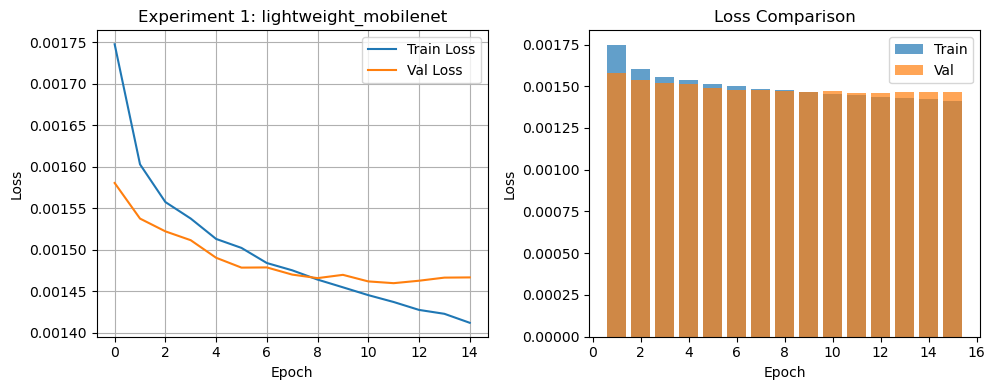

\nNext steps:
  • Try different backbones: 'simple', 'resnet18'
  • Try different heads: 'deconv'
  • Try different losses: 'smooth_l1'
  • Increase epochs for better convergence


In [17]:
if results_1:
    print("\\nExperiment 1 Results:")
    print(f"  • Final train loss: {results_1['train_losses'][-1]:.4f}")
    print(f"  • Best val loss: {results_1['best_val_loss']:.4f}")
    print(f"  • Model parameters: {results_1['model_params']:,}")
    print(f"  • Model saved as: {experiment_1['name']}_best.pth")

    # Plot training curves
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(results_1['train_losses'], label='Train Loss')
    plt.plot(results_1['val_losses'], label='Val Loss')
    plt.title(f"Experiment 1: {experiment_1['name']}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    epochs = range(1, len(results_1['train_losses']) + 1)
    plt.bar(epochs, results_1['train_losses'], alpha=0.7, label='Train')
    plt.bar(epochs, results_1['val_losses'], alpha=0.7, label='Val')
    plt.title('Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\\nNext steps:")
    print("  • Try different backbones: 'simple', 'resnet18'")
    print("  • Try different heads: 'deconv'")
    print("  • Try different losses: 'smooth_l1'")
    print("  • Increase epochs for better convergence")
else:
    print("ERROR: Experiment 1 failed. Check Phase 1 data availability.")

## More Experiments (Ready to Run)

In [16]:
# ============================================================================
# MORE EXPERIMENT EXAMPLES - UNCOMMENT TO RUN
# ============================================================================

# Example 2: Balanced accuracy vs speed
experiment_2 = {
    'name': 'balanced_resnet18',
    'backbone': 'resnet18',
    'head': 'deconv',
    'loss': 'smooth_l1',
    'epochs': 20,
    'lr': 5e-4,
    'batch_size': 6
}

# Example 3: Simple and fast
experiment_3 = {
    'name': 'simple_fast',
    'backbone': 'simple',
    'head': 'simple',
    'loss': 'mse',
    'epochs': 10,
    'lr': 1e-3,
    'batch_size': 12
}

# Example 4: High quality training
experiment_4 = {
    'name': 'high_quality',
    'backbone': 'resnet18',
    'head': 'deconv',
    'loss': 'smooth_l1',
    'epochs': 50,
    'lr': 1e-4,
    'batch_size': 4
}

print("Additional experiments ready!")
print("\\nAvailable configurations:")
print("  • experiment_2: Balanced (ResNet18 + Deconv + Smooth L1)")
print("  • experiment_3: Simple & Fast (Simple + Simple + MSE)")
print("  • experiment_4: High Quality (ResNet18 + Deconv + Long training)")

print("\\n▶️  To run any experiment, simply:")
print("     results = run_experiment(experiment_2)")

print("\\nAvailable options:")
print("  • Backbones: 'simple', 'resnet18', 'mobilenet_v2'")
print("  • Heads: 'simple', 'deconv'")
print("  • Losses: 'mse', 'smooth_l1'")

print("\\nCreate your own experiment:")
print("""
custom_experiment = {
    'name': 'my_experiment',
    'backbone': 'resnet18',
    'head': 'deconv',
    'loss': 'smooth_l1',
    'epochs': 25,
    'lr': 1e-3,
    'batch_size': 8
}
results = run_experiment(custom_experiment)
""")

Additional experiments ready!
\nAvailable configurations:
  • experiment_2: Balanced (ResNet18 + Deconv + Smooth L1)
  • experiment_3: Simple & Fast (Simple + Simple + MSE)
  • experiment_4: High Quality (ResNet18 + Deconv + Long training)
\n▶️  To run any experiment, simply:
     results = run_experiment(experiment_2)
\nAvailable options:
  • Backbones: 'simple', 'resnet18', 'mobilenet_v2'
  • Heads: 'simple', 'deconv'
  • Losses: 'mse', 'smooth_l1'
\nCreate your own experiment:

custom_experiment = {
    'name': 'my_experiment',
    'backbone': 'resnet18',
    'head': 'deconv',
    'loss': 'smooth_l1',
    'epochs': 25,
    'lr': 1e-3,
    'batch_size': 8
}
results = run_experiment(custom_experiment)

